# Deep Learning

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",15)
%matplotlib inline

sess = tf.InteractiveSession()

In [2]:
tf.reset_default_graph()

input_dim = 122
classes = 2
hidden_encoder_dim = 80

latent_dim = 10

hidden_decoder_dim = 80

lam = 0.01

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.001)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

l2_loss = tf.constant(0.001)
#learning_rate = tf.Variable(initial_value=0.001)

with tf.variable_scope("Input"):
    x = tf.placeholder("float", shape=[None, input_dim])
    y_ = tf.placeholder("float", shape=[None, classes])
    
    keep_prob = tf.placeholder("float")

with tf.variable_scope("Layer_Encoder"):
    W_encoder_input_hidden = weight_variable([input_dim,hidden_encoder_dim])
    b_encoder_input_hidden = bias_variable([hidden_encoder_dim])
    l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)

    # Hidden layer encoder
    hidden_encoder = tf.nn.relu(tf.matmul(x, W_encoder_input_hidden) + b_encoder_input_hidden)
    tf.summary.histogram("Weights_Encoder", W_encoder_input_hidden)
    hidden_encoder = tf.nn.dropout(hidden_encoder, keep_prob=keep_prob)

with tf.variable_scope("Layer_Mean"):
    W_encoder_hidden_mu = weight_variable([hidden_encoder_dim,latent_dim])
    b_encoder_hidden_mu = bias_variable([latent_dim])
    l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)

    # Mu encoder
    mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + b_encoder_hidden_mu
    tf.summary.histogram("Weights_Mean", W_encoder_hidden_mu)

with tf.variable_scope("Layer_Variance"):
    W_encoder_hidden_logvar = weight_variable([hidden_encoder_dim,latent_dim])
    b_encoder_hidden_logvar = bias_variable([latent_dim])
    l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)

    # Sigma encoder
    logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + b_encoder_hidden_logvar
    tf.summary.histogram("Weights_Variance", W_encoder_hidden_logvar)

with tf.variable_scope("Sampling_Distribution"):
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')

    # Sample latent variable
    std_encoder = tf.exp(0.5 * logvar_encoder)
    z = mu_encoder + tf.multiply(std_encoder, epsilon)
    tf.summary.histogram("Sample_Distribution", z)
    
with tf.variable_scope("Layer_Decoder"):
    W_decoder_z_hidden = weight_variable([latent_dim,hidden_decoder_dim])
    b_decoder_z_hidden = bias_variable([hidden_decoder_dim])
    l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)

    # Hidden layer decoder
    hidden_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_hidden) + b_decoder_z_hidden)
    hidden_decoder = tf.nn.dropout(hidden_decoder, keep_prob=keep_prob)
    tf.summary.histogram("Weights_Decoder", W_decoder_z_hidden)

with tf.variable_scope("Layer_Reconstruction"):
    W_decoder_hidden_reconstruction = weight_variable([hidden_decoder_dim, input_dim])
    b_decoder_hidden_reconstruction = bias_variable([input_dim])
    l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)

    x_hat = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) + b_decoder_hidden_reconstruction
    tf.summary.histogram("Weights_Reconstruction", W_decoder_hidden_reconstruction)

with tf.variable_scope("Layer_Dense_Hidden"):
    hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

with tf.variable_scope("Layer_Dense_Softmax"):
    y = tf.layers.dense(z, classes, activation=tf.nn.softmax)
    
with tf.variable_scope("Loss"):
    BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x), reduction_indices=1)
    KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
    loss_softmax = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))
    
    loss_vae = tf.reduce_mean(BCE + KLD)
    
    loss_regularized_vae = tf.abs(loss_vae + lam * l2_loss, name = "Regularized_loss")
    
    
    pred = tf.argmax(y, 1)
    actual = tf.argmax(y_, 1)
    
    #tf.summary.scalar("BCE", BCE)
    #tf.summary.scalar("KLD", KLD)
    #tf.summary.scalar("Softmax_loss", softmax_loss)
    
    tf.summary.scalar("loss", loss_regularized_vae)
    
with tf.variable_scope("Optimizer_VAE"):
    learning_rate=0.001
    grad_clip=5
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss_regularized_vae, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer_vae = train_op.apply_gradients(zip(grads, tvars))

with tf.variable_scope("Optimizer_Softmax"):
    optimizer_softmax = tf.train.AdamOptimizer(0.0001).minimize(loss_softmax)

correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

# add op for merging summary
summary_op = tf.summary.merge_all()

# add Saver ops
# saver = tf.train.Saver()

In [3]:
kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")


output_columns_2labels = ['is_Attack','is_Normal']

from sklearn import model_selection as ms
from sklearn import preprocessing as pp

x_input = kdd_train_2labels.drop(output_columns_2labels, axis = 1)
y_output = kdd_train_2labels.loc[:,output_columns_2labels]

ss = pp.StandardScaler()

x_input = ss.fit_transform(x_input)

x_test = kdd_test_2labels.drop(output_columns_2labels, axis = 1)
y_test = kdd_test_2labels.loc[:,output_columns_2labels]

x_test = ss.transform(x_test)


In [4]:
epochs = 40
batch_iterations = 100



with tf.Session() as sess:
    summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
    summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

    sess.run(tf.global_variables_initializer())

    for epoch in range(0, epochs):
        x_train, x_valid, y_train, y_valid = ms.train_test_split(x_input, 
                                                                  y_output.values, 
                                                                  test_size=0.2)
        #x_valid, x_test, y_valid, y_test = ms.train_test_split(x_valid, y_valid, test_size = 0.4)
        batch_indices = np.array_split(np.arange(x_train.shape[0]), batch_iterations)
        
        for i in batch_indices:
            _, train_loss, summary_str = sess.run([optimizer_vae, loss_regularized_vae, summary_op],
                                                  feed_dict={x: x_train[i,:], y_: y_train[i,:], keep_prob:0.6})

        if epoch % 2 == 0:
            print("Step {} | Training Loss: {:.4f}".format(epoch, train_loss))
        
    for epoch in range(0, epochs):
        x_train, x_valid, y_train, y_valid = ms.train_test_split(x_input, 
                                                                  y_output.values, 
                                                                  test_size=0.2)
        #x_valid, x_test, y_valid, y_test = ms.train_test_split(x_valid, y_valid, test_size = 0.4)
        batch_indices = np.array_split(np.arange(x_train.shape[0]), batch_iterations)
        
        for i in batch_indices:
            _, train_loss, summary_str = sess.run([optimizer_softmax, loss_softmax, summary_op],
                                                  feed_dict={x: x_train[i,:], y_: y_train[i,:], keep_prob:0.6})
        
        accuracy, summary_str = sess.run([tf_accuracy, summary_op], 
                                              feed_dict={x: x_valid, y_:y_valid, keep_prob:1})
        summary_writer_valid.add_summary(summary_str, epoch)
            
        if epoch % 2 == 0:
            print("Step {} | Training Loss: {:.4f} | Validation Accuracy: {:.4f}".format(epoch, train_loss, accuracy))
            
            
            
    accuracy, pred_value, actual_value = sess.run([tf_accuracy, pred, actual], feed_dict={x: x_test, y_:y_test, keep_prob:1})
    
    print("Accuracy on Test data: {}".format(accuracy))

Step 0 | Training Loss: 0.4107
Step 2 | Training Loss: 0.0292
Step 4 | Training Loss: 0.1480
Step 6 | Training Loss: 0.0547
Step 8 | Training Loss: 0.0545
Step 10 | Training Loss: 0.0782
Step 12 | Training Loss: 0.0061
Step 14 | Training Loss: 0.0097
Step 16 | Training Loss: 0.0364
Step 18 | Training Loss: 0.0030
Step 20 | Training Loss: 0.0188
Step 22 | Training Loss: 0.0372
Step 24 | Training Loss: 0.0230
Step 26 | Training Loss: 0.0009
Step 28 | Training Loss: 0.0099
Step 30 | Training Loss: 0.0154
Step 32 | Training Loss: 0.0094
Step 34 | Training Loss: 0.0316
Step 36 | Training Loss: 0.0223
Step 38 | Training Loss: 0.0602
Step 0 | Training Loss: 0.7568 | Validation Accuracy: 0.4649
Step 2 | Training Loss: 0.5088 | Validation Accuracy: 0.8083
Step 4 | Training Loss: 0.4192 | Validation Accuracy: 0.9272
Step 6 | Training Loss: 0.3831 | Validation Accuracy: 0.9501
Step 8 | Training Loss: 0.3641 | Validation Accuracy: 0.9633
Step 10 | Training Loss: 0.3556 | Validation Accuracy: 0.969

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.6345  0.3655]
 [ 0.0753  0.9247]]


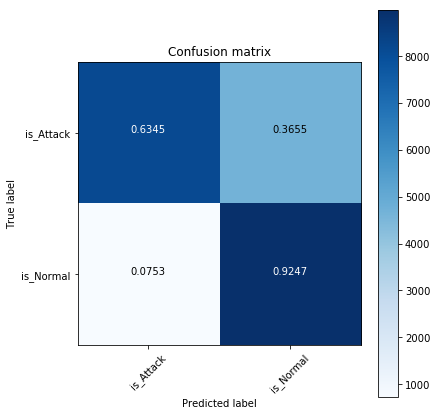

In [6]:
from sklearn.metrics import confusion_matrix
cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
plt.figure(figsize=[6,6])
plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)